## Model

### Equations
* From https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model , without considering natural birth and death rate.

\begin{equation}
\begin{split}
\dot{S} &= -\frac{\beta I S}{N}\\
\dot{I} &= \frac{\beta I S}{N} - \gamma I - \mu I\\
\dot{R} & = \gamma I\\
\dot{D} & = \mu I
\end{split}
\end{equation}

### Variables
* $S$: Susceptible individuals
* $I$: Infected individuals
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+I+R+D$ Total population size (constant)

### Parameters
* $\beta$ rate at which infected individuals contact susceptibles and infect them
* $\gamma$ rate at which infected individuals recover from disease and become immune
* $\mu$ death rate for infected individuals

### Basic reproductive ratio
* From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7438206/
\begin{equation}
R_0 = \frac{\beta}{\gamma + \mu}
\end{equation}

## SIRD Simulation

Import libaries.

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

Define SIRD model.

In [2]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

Simulation with given parameters.

In [3]:
# Define parameters and run ODE

# test for Kaohsiung
N = 2700000
b = 0.3 #beta
g = 0.16 #gamma
u = 0.0002 # mu

#Calculate basic reproductive ratio
R0 = b / (g + u)
print("R0 = {0:4.2f}".format(R0))

R0 =  1.9


Plot on linear and log scale.

<class 'numpy.ndarray'>


(1, 20000)

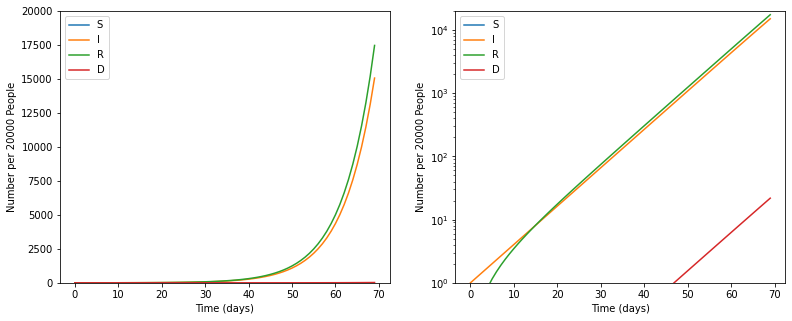

In [4]:
tmax = 70 # time length
tvec = np.arange(0, tmax, 1)
ic = np.zeros(3)
ic[0] = 1

soln = odeint(SIRD, ic, tvec, args=(b, g, u, N))
soln = np.hstack((1 - np.sum(soln, axis=1, keepdims=True), soln))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(tvec, soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
plt.ylim([0, 20000])

#Same plot but on log scale
plt.subplot(1, 2, 2)
plt.plot(tvec, soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 20000 People")
plt.legend(("S", "I", "R", "D"))
plt.ylim([1, 20000])
#plt.tight_layout()

Get growth rate.

In [109]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec, soln, t1, t2, i):
  i1 = np.where(tvec == t1)[0][0]
  i2 = np.where(tvec == t2)[0][0]
  r = (np.log(soln[i2, 1]) - np.log(soln[i1, 1])) / (t2 - t1)
  DoublingTime=np.log(2) / r

  return r, DoublingTime

In [110]:
(r, DoublingTime)=growth_rate(tvec, soln, 10, 20, 1)
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r, DoublingTime))

The epidemic growth rate is = 0.14 per day and the doubling time  5.0 days 


## Estimate SIRD Model with Grid Search (Start from Here!!!)
* Reference: https://github.com/Lewuathe/COVID19-SIR/blob/master/solver.py

Import libaries.

In [27]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

Define SIRD model.

In [2]:
#Defining the differential equations
#Don't track S because all variables must add up to N

def SIRD(y, t, b, g, u, N): 
    dy=[0, 0, 0] # I, R, D
    S = N - sum(y);
    dy[0] = b*S*y[0]/N-(g+u)*y[0] # dI
    dy[1] = g*y[0] # dR
    dy[2] = u*y[0] # dD

    return dy

Calculate mean square error for I and R.

In [3]:
def MSE(new_infected_data, recovered_data, N, b, g, u):
    tmax = len(new_infected_data)
    tvec = np.arange(0, tmax, 1)
    ird = np.zeros(3)
    ird[0] = 1

    soln = odeint(SIRD, ird, tvec, args=(b, g, u, N)).transpose()

    lossI = np.sqrt(np.mean(np.power(soln[0] - new_infected_data, 2)))
    lossR = np.sqrt(np.mean(np.power(soln[1] - recovered_data, 2)))
    return lossI + lossR

Search parameters with minimal MSE.

In [4]:
def gridSearch(N, new_infected_data, recovered_data):
    minError = np.infty
    best_b, best_g, best_u = -1, -1, -1

    for b in np.arange(0.1, 0.5, 0.01):
        for g in np.arange(0.05, 0.3, 0.01):
            u = 0.00018     # fixed death rate
            
            error = MSE(new_infected_data, recovered_data, N, b, g, u)
            if error < minError:
                best_b, best_g, best_u = b, g, u
                minError = error

    return best_b, best_g, best_u


Plot estimated and real new cases on linear and log scale.

In [5]:
def plotEsti(new_infected_data, N, b, g, u):
    tvec = np.arange(0, len(new_infected_data), 1)
    soln = odeint(SIRD, np.array([1, 0, 0]), tvec, args=(b, g, u, N))
    soln = np.vstack((soln[:, 0], new_infected_data)).transpose()

    plt.figure(figsize=(13, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tvec, soln)
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    # plt.ylim([0,20000])

    #Same plot but on log scale
    plt.subplot(1, 2, 2)
    plt.plot(tvec, soln)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of New Cases")
    plt.legend(("estimation", "reality"))
    # plt.ylim([1,20000])
    # plt.tight_layout()

Estimate recovered cases.
$$
R(t) = \begin{cases}
0.995I(t-7), &\text{if $t \geq 7$}\\
0, &\text{otherwise}
\end{cases}
$$

In [6]:
def estiRecovered(new_infected_data):
    recovered_data = []
    for i in range(len(new_infected_data)):
        if i - 7 >= 0:
            recovered_data.append(int(new_infected_data[i-7] * 0.995))
        else:
            recovered_data.append(0)
    return np.array(recovered_data)

Estimate parameters for one city or Taiwan.

In [7]:
def estiCity(N, new_infected_data):
    # Kaohsiung data
    # new_infected_data = np.array([1,3,1,1,2,1,11,4,1,3,2,3,2,4,6,6,1,5,34,36,50,30,25,30,49,63,45,50,59,41,26,50,106,68,121,96,135,152,198,269,352,393,468,441,679,818,1042,1183,1782,2180,2076,1981,2069,3740,3326,3754,3886,3990,4341,5086,6967,6818,7788,7858,7451,7450,9774,9985,8809,11636,10023,9915,8616,10832,11728,10529])
    # N = 2700000    # city population
    recovered_data = estiRecovered(new_infected_data)
    b, g, u = gridSearch(N, new_infected_data, recovered_data)

    print(f"Best parameters: b = {b}, g = {g}, u = {u}")
    print(f"Minimal MSE = {MSE(new_infected_data, recovered_data, N, b, g, u)}")
    plotEsti(new_infected_data, N, b, g, u)

Read city data from file.

City: NWT
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: TPE
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: TXG
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: KHH
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: TTT
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: PEN
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707
City: TW
Best parameters: b = 0.48999999999999977, g = 0.05, u = 0.00018
Minimal MSE = 1.0873872865588707


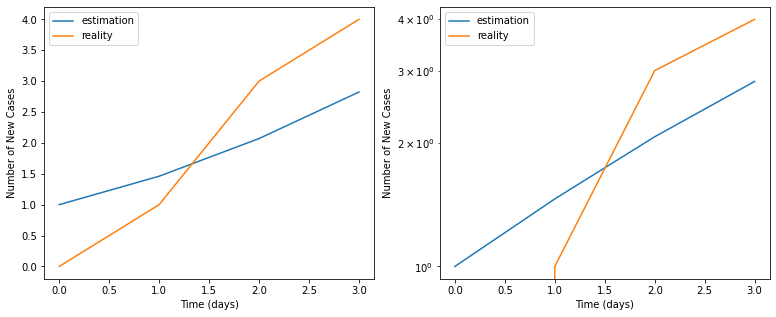

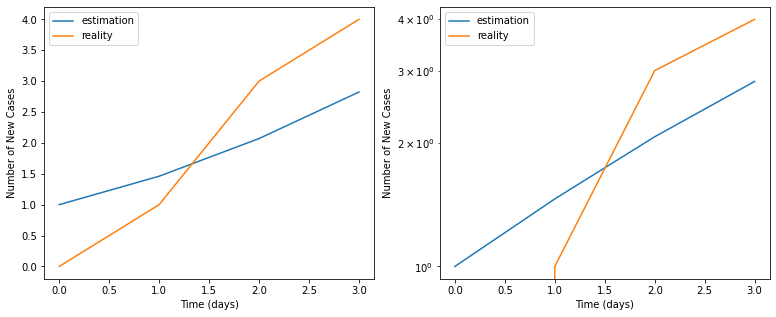

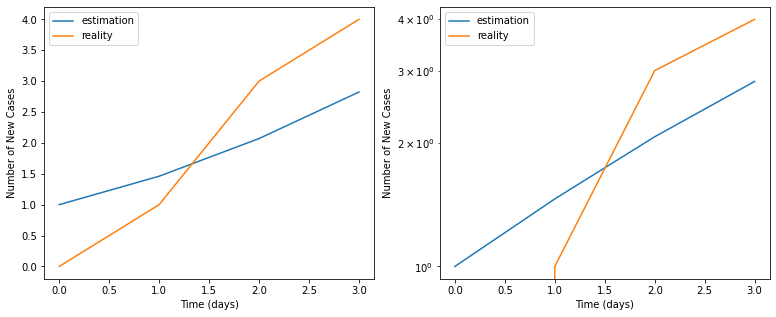

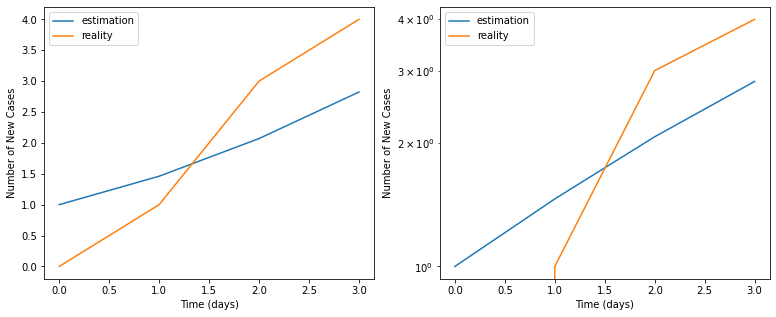

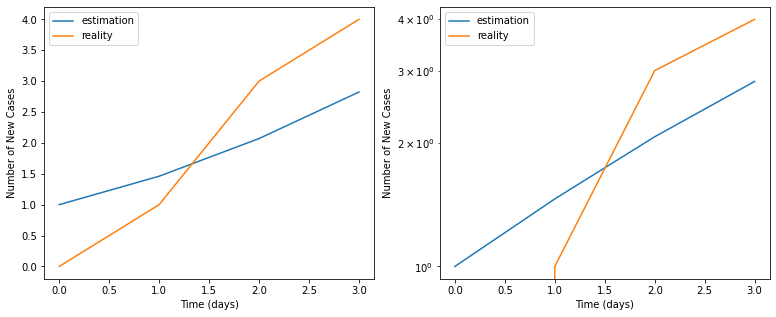

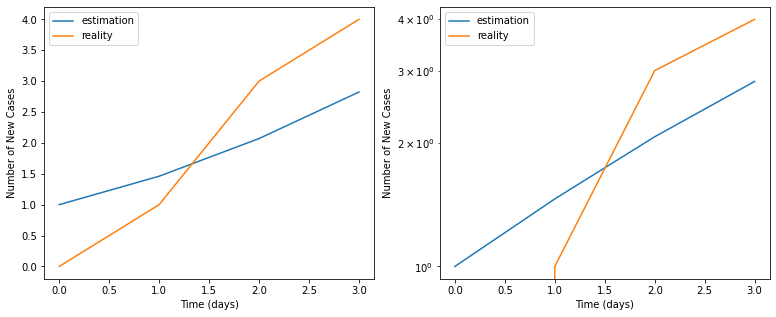

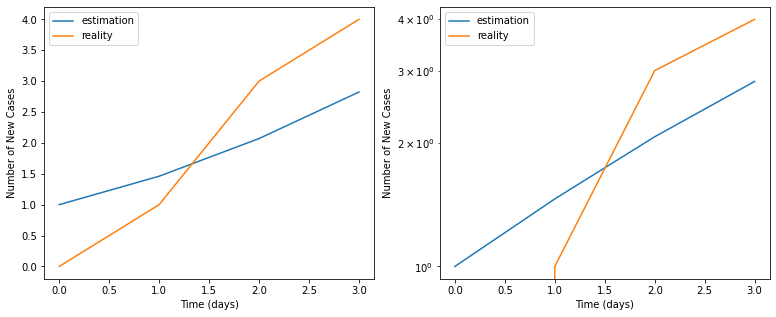

In [8]:
# TODO: read from file: diagnosed, population

# city_code = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE", "TW"]
city_code = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN", "TW"]

for city in city_code:
    # get new_infected_data for each city
    new_infected_data = np.array([0, 1, 3, 4])  # for test
    population = 10         # for test
    print(f"City: {city}")
    estiCity(population, new_infected_data)


## Source Reference
* https://colab.research.google.com/github/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb